#  **Photolithography** 

### __Before you start the notebook please run the import section bellow.__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import math
from IPython.display import display, Markdown, clear_output
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.fftpack import fft2, ifft2, fftshift
from ipywidgets import interact
import ipywidgets as widgets

**Photolithography** is a fundamental technique widely employed in microfabrication processes to pattern and define complex features on substrates with high precision. It is a key process in the production of microelectronic devices, integrated circuits, microfluidic systems, and various other microscale structures.

It is based on the principle of electromagnetic interaction and the modification of a resist material through the exposure to photons or electrons. The resist material is a photosensitive material that undergoes a chemical or physical change upon exposure. The patterned resist acts as a mask for subsequent processes, defining regions that will either be selectively etched or where materials will be deposited.

The **lithography** process begins with the **design of the desired pattern**, typically using computer-aided design (CAD) software. The design is then transferred to a photomask, which contains the pattern as opaque and transparent regions. The mask serves as a template for pattern transfer onto the resist-coated substrate.

During **exposure**, the resist is here subjected to UV light ; the photons or electrons interact with the resist, inducing chemical reactions or physical changes in the material. This modification of the resist's properties enables the creation of a pattern corresponding to the desired design.

Following exposure, the resist undergoes a **development** step. Development involves treating the resist with a developer solution that selectively removes either the exposed since here we are using a positive resist. This step reveals the patterned resist on the substrate, ready for subsequent processing step.

photo + video

# *Exercice Section*
* # Dose of expostion



To achieve proper development results, it is important to choose the exposure dose carefully. Before diving into further details, let's analyze the recommended dose for a specific thickness of AZ 1512 HS resist on the MABA6 and MA6 Gen3 machines. Please be aware that the presented curve is specific to this particular case and is provided to give you an idea of the potential behavior you might encounter.

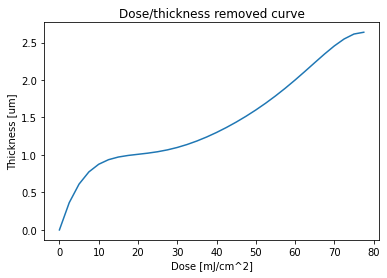

In [6]:
# Determine the number of points and the values of doses, for the interpolation
dose = np.arange(0, 80, 2.5, float) 
thickness= -3.08555*10**-10*dose**6 + 7.88354*10**-8*dose**5-8.17055*10**-6*dose**4+0.000437742*dose**3-0.012214*dose**2+0.173364*dose+0
    
# Plot
plt.title('Dose/thickness removed curve')
plt.plot(dose, thickness)
plt.ylabel('Thickness [um]')
plt.xlabel('Dose [mJ/cm^2]')
plt.show()

Is this relation linear ? Quadratic ? Something else ?


* # Photolithography simulation



In this exercise, the initial step involves creating your own mask using KLayout. Once the mask is created, you can proceed to import the corresponding text file into the code (see further). However, it is important to note that prior to importing, you should remove all lines from the text file except those that contain the coordinates of the mask's corners. For example, considering the provided mask as an example, the text file would appear as follows:

-456989: 60480 \
-456989: 62972 \
-455490: 62972 \
-455490: 65536 \
-454990: 65536 \
-454990: 62999 \
-452520: 62990 \
-452520: 65472 \
-451520: 65472 \
-451520: 62981 \
-448484: 62981 \
-448484: 65500 \
-446484: 65500 \
-446484: 60480 \
-456989: 60480

After importing your mask, make sure to replace "open("mask1_klayout_me.txt", "r")" with "open("your_file_name.txt", "r")". It's important to note that you can also utilize the provided mask1_klayout_me as an example for this exercise. However, keep in mind that it does not possess the necessary shape and size required for the creation of the microheater.


Upon running the code, three distinct figures will be generated, depending on the light source that you chose. The first figure depicts the 3D light intensity profile within the mask. The second figure displays a cross-section of the 2D mask, including the light intensity profile, the threshold value necessary for development, and the development function represented as a binary function (indicating whether a zone is fully developed or not developed at all). Finally, the last figure illustrates the disparity between your mask and the areal image, which represents the pattern obtained after the photolithography process. 

Feel free to execute the code and explore the various parameters to enhance your experience!

In [3]:
# Parameters
global N
N = 500               #number of points on the x and y scales
TH = 70               # Threshold intensity (normalized)
NA = 1             # Numerical aperature
global prev_value
prev_value = 'ArF excimer laser'

# Reading mask shape from file
with open("mask1_klayout_me.txt", "r") as file:
    data = file.readlines()
X = []
Y = []
for line in data:
    line = line.strip().split(":")
    X.append(int(line[0])/1000.)
    Y.append(int(line[1])/1000.)
num_points = len(X)-1
sides = np.zeros(num_points)
for i in range(num_points):
    sides[i] = np.sqrt((X[i]-X[i+1])**2 + (Y[i]-Y[i+1])**2) #compute the distance between consecutive points
X = X-np.min(X)
Y = Y-np.min(Y)
Lx = 1.4*np.max(X)    # Mask real dimensions (um), dimension increased to have the black area around the mask
Ly = 1.4*np.max(Y)    # Mask real dimensions (um)
dx = Lx/(N-1)
dy = Ly/(N-1)


def plot_mask(lamda, D_exp):
    # Center the polygon
    dx = Lx/(N-1) #pixel resolution 
    dy = Ly/(N-1)
    x = np.linspace(-0.2*np.max(X),1.2*np.max(X),N)
    y = np.linspace(-0.2*np.max(Y),1.2*np.max(Y),N)
    # Create mask matrix
    x,y = np.meshgrid(x,y)
    x = np.reshape(x,-1) #flatten the array
    y = np.reshape(y,-1)
    mask = Path(np.column_stack((X,Y))) #polygon defined by the points (X,Y) (in .txt)
    mask = mask.contains_points(np.column_stack((x,y))) #compute if (x, y) is in the polygone : 1 if inside, 0 if outside, length = N*N
    mask = np.reshape(mask,(N,N)) 
    mask = mask.astype(float)
    print('The dimensions of the mask are', round(Lx,2), 'x', round(Ly,2), 'um')
    
    # Calculations creating different domains
    nx, ny = np.meshgrid(np.arange(-(N-1)/2,(N-1)/2+1),np.arange(-(N-1)/2,(N-1)/2+1))
    fx = (1/dx)*(1/N)*nx
    fy = (1/dx)*(1/N)*ny
    
    # Discrete frequency domain (1/um)
    P = np.sqrt((fx**2)+(fy**2))
    P = (P < (NA/lamda)).astype(float) #diffraction limit : maximum spatial frequency that can be captured
    I = fftshift(fft2(mask))
    I = ifft2(P*I)
    I = np.real(I*np.conj(I)) #norm of complex values
    I = I/np.max(I) #normalized
    phys_I = I*D_exp 
    aerial = (phys_I > TH).astype(float)
    
    # Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(mask, cmap='gray', origin='lower',  extent=(0, N*dx, 0, N*dy))
    ax1.set_title('Mask image')
    ax1.set_xlabel('X [um]')
    ax1.set_ylabel('Y [um]')
    ax2.imshow(aerial, cmap='gray', origin='lower', extent=(0, N*dx, 0, N*dy))
    ax2.set_title('Aerial image')
    ax2.set_xlabel('X [um]')
    ax2.set_ylabel('Y [um]') 
    plt.tight_layout()


def update_3D(lamda,N, D_exp):
    # Center the polygon
    x = np.linspace(-0.2*np.max(X),1.2*np.max(X),N)
    y = np.linspace(-0.2*np.max(Y),1.2*np.max(Y),N)
    # Create mask matrix
    x,y = np.meshgrid(x,y)
    x = np.reshape(x,-1)
    y = np.reshape(y,-1)
    mask = Path(np.column_stack((X,Y)))
    mask = mask.contains_points(np.column_stack((x,y)))
    mask = np.reshape(mask,(N,N))
    mask = mask.astype(float)
    # Calculations creating different domains
    dx = Lx/(N-1)
    dy = Ly/(N-1)
    nx, ny = np.meshgrid(np.arange(-(N-1)/2,(N-1)/2+1),np.arange(-(N-1)/2,(N-1)/2+1))
    fx = (1/dx)*(1/N)*nx
    fy = (1/dx)*(1/N)*ny
    # Discrete frequency domain (1/um)
    P = np.sqrt((fx**2)+(fy**2))
    P = (P < (NA/lamda)).astype(float)
    I = fftshift(fft2(mask))
    I = ifft2(P*I)
    I = np.real(I*np.conj(I)) 
    I = I/np.max(I) 
    phys_I = I*D_exp #Dose [mJ/cm^2]
    aerial = (phys_I > TH).astype(float)
    return nx, ny, phys_I, dx
    
# Define the function to plot
def plot_func(lamda,D_exp):
    nx, ny, I, dx = update_3D(lamda,N, D_exp)
    x = np.linspace(0, N*dx, N)  # Adjust x-axis values
    y = np.linspace(0, N*dy, N)  # Adjust y-axis values
    nx, ny = np.meshgrid(x, y)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(nx, ny, I, cmap='jet')    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


def plot_func_2D(lamda, y_pixel, D_exp):
    nx, ny, I, dx = update_3D(lamda,N, D_exp)
    x = np.linspace(0, N*dx, N)  # Adjust x-axis values

    plt.plot(x, I[y_pixel,:], label='Intensity function')
    plt.plot(x, ~(I[y_pixel,:] > TH)*D_exp, label='Development function')
    plt.axhline(TH, color='red', linestyle='--', label='Threshold for development')
    plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))
    arr = np.where((I[y_pixel,:] > TH))[0]  #list of index where the intensity is higher than the threshold
    output = []
    temp = []
    dist = []
    if(len(arr) != 0):
        for i, val in enumerate(arr[:-1]):
            temp.append(val)
            if arr[i+1] != val +1:
                output.append(temp)
                temp = []
        temp.append(arr[-1])
        output.append(temp)
        for j in range(len(output)):
            x_left_out=output[j][0]-1
            x_right_out=output[j][len(output[j])-1]+1
            I_left_in=I[y_pixel,output[j][0]]
            I_left_out=I[y_pixel,x_left_out]
            I_right_in=I[y_pixel,output[j][len(output[j])-1]]
            I_right_out=I[y_pixel,x_right_out]                
            dist.append((x_right_out-x_left_out-(TH-I_right_out)/(I_right_in-I_right_out)-(TH-I_left_out)/(I_left_in-I_left_out))*dx) 
        print('The width of the opening are :')
        for d in dist:
            print('{:.2f} [um]'.format(d))
    print('You are at position y =', round(float(y_pixel*dy),2), ' [um]')
    print('The dose is', D_exp, '[mJ/cm^2]')

    plt.xlabel('X [um]')
    plt.ylabel('Z')
    plt.show()
    

# buttons creation
button = widgets.Dropdown(
       options=['F2 laser', 'ArF excimer laser', 'Hg/Xe arc lamp (DUV)', 'Hg arc lamp (I-line)', 'Hg arc lamp (H-line)', 'Hg arc lamp (G-line)'],
       description='Light source:')
output = widgets.Button(description='Select')
outt = widgets.Output()

def on_butt_clicked(b):
    with outt:
        global prev_value
        global lamda 
        clear_output()
        if(button.value != prev_value):
            if(button.value == 'F2 laser'):
                prev_value = 'F2 laser'
                lamda = 0.157 
            elif(button.value == 'ArF excimer laser'):
                prev_value = 'ArF excimer laser'
                lamda = 0.193
            elif(button.value == 'Hg/Xe arc lamp (DUV)'):
                prev_value = 'Hg/Xe arc lamp (DUV)'
                lamda = 0.248  
            elif(button.value == 'Hg arc lamp (I-line)'):
                lamda = 0.365  
            elif(button.value == 'Hg arc lamp (H-line)'):
                lamda = 0.405  
            elif(button.value == 'Hg arc lamp (G-line)'):
                lamda = 0.436  
        print('Wavelength = ', lamda, 'um')  
        interact(plot_func,  lamda=fixed(lamda), D_exp = (0, 200, 1))
        interact(plot_func_2D,  lamda=fixed(lamda), y_pixel = (0, N-1, 1), D_exp = (0, 200,  1))
        interact(plot_mask,  lamda=fixed(lamda), D_exp = (0, 200, 1))




output.on_click(on_butt_clicked)
widgets.VBox([button,output,outt]) 

## __This is the end of the photolithography section.__
## __Please go back to the main notebook and fill the required data from what you found here.__
## __You can go to the next notebook "thin film".__
